# Requirements

In [2]:
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit

from src.settings import LOGS_ROOT

sns.set(rc = {'figure.figsize':(8,8)})
sns.set_style("whitegrid")

# A smarter approach for results

## Data load

In [4]:
# ABIDE 869
ds = "ABIDE 869"
data_paths = [
    LOGS_ROOT.joinpath("220716.075108-experiment-mlp-abide_869/k_0/0002/scores.npz"),
    LOGS_ROOT.joinpath("220716.075108-experiment-mlp-abide_869/k_1/0009/scores.npz"),
    LOGS_ROOT.joinpath("220716.075108-experiment-mlp-abide_869/k_2/0008/scores.npz"),
    LOGS_ROOT.joinpath("220716.075108-experiment-mlp-abide_869/k_3/0004/scores.npz"),
    LOGS_ROOT.joinpath("220716.075108-experiment-mlp-abide_869/k_4/0000/scores.npz")
]
accuracies = [0.655, 0.684, 0.713, 0.747, 0.746]
AUCs = [0.6912234042553193, 0.7150265957446809, 0.7523936170212767, 0.8257161892071951, 0.7970643684352275]


In [3]:
# OASIS
ds = "OASIS"
data_paths = [
    LOGS_ROOT.joinpath("220721.184622-experiment-mlp-oasis/k_0/0001/scores.npz"),
    LOGS_ROOT.joinpath("220721.184622-experiment-mlp-oasis/k_1/0002/scores.npz"),
    LOGS_ROOT.joinpath("220721.184622-experiment-mlp-oasis/k_2/0008/scores.npz"),
    LOGS_ROOT.joinpath("220721.184622-experiment-mlp-oasis/k_3/0002/scores.npz"),
    LOGS_ROOT.joinpath("220721.184622-experiment-mlp-oasis/k_4/0005/scores.npz")
]
accuracies = [0.8181818181818182, 0.8, 0.8121212121212121, 0.8414634146341463, 0.8597560975609756]
AUCs = [0.855410866636731, 0.7151648351648352, 0.7371428571428571, 0.8031674208144797, 0.8404977375565611]


In [15]:
# FBIRN
ds = "FBIRN"
data_paths = [
    LOGS_ROOT.joinpath("220721.175931-experiment-mlp-fbirn/k_0/0008/scores.npz"),
    LOGS_ROOT.joinpath("220721.175931-experiment-mlp-fbirn/k_1/0008/scores.npz"),
    LOGS_ROOT.joinpath("220721.175931-experiment-mlp-fbirn/k_2/0004/scores.npz"),
    LOGS_ROOT.joinpath("220721.175931-experiment-mlp-fbirn/k_3/0003/scores.npz"),
    LOGS_ROOT.joinpath("220721.175931-experiment-mlp-fbirn/k_4/0005/scores.npz")
]
accuracies = [0.8095238095238095, 0.7903225806451613, 0.7741935483870968, 0.8709677419354839, 0.7580645161290323]
AUCs = [0.8477822580645161, 0.8104166666666667, 0.875, 0.8989583333333333, 0.8645833333333333]

In [4]:
data_list = []
for data_path in data_paths:
    data_list.append(np.load(data_path))

logits_list = []
targets_list = []
for data in data_list:
    logits_list.append(data["logits"])
    targets_list.append(data["targets"])

data_list = []

for logits, targets in zip(logits_list, targets_list):
    data_list.append(
        pd.DataFrame(
            {
                "y0": logits_list[ :, 0],
                "y1": logits_list[ :, 1],
                "class": targets,
            }
        )
    )

## Logistic regression

In [7]:
from sklearn.linear_model import LogisticRegression

X_list = []
y_list = []

for data in data_list:
    X_list.append(data.to_numpy()[ :, 0:2])
    y_list.append(data.to_numpy()[ :, 2].astype(int))

coef_list = []
intercept_list = []
scores = []
for X, y in zip(X_list, y_list):
    clf = LogisticRegression(random_state=0).fit(X, y)
    coef_list.append(clf.coef_)
    intercept_list.append(clf.intercept_)
    scores.append(clf.predict_proba(X))

In [ ]:
for i in range(len(data_list)):
    # Fold i, Accuracy = accuracies[i]
    X_plot = np.linspace(2, 5, 100)
    Y_plot = -coef_list[i][0, 0]/coef_list[i][0, 1]*X_plot - intercept_list[i][0]/coef_list[i][0, 1]

    sns.scatterplot(data=data_list[i], x="y0", y="y1", hue="class", alpha=0.7)

    plt.plot(X_plot, Y_plot, color='r')
    plt.title(f"{ds}, Fold {i+1}, Accuracy = {accuracies[i]:.3f}, AUC = {AUCs[i]:.3f}")
    plt.savefig(f"{ds}-{i}.png", dpi=150)

    plt.clf()

## Tune threshold

In [12]:
import torch
from sklearn.metrics import accuracy_score
from numpy import arange

tuned_accuracies = []
tuned_thresholds = []
thresholds = arange(0, 1, 0.001)

for i in range(len(data_list)):
    temp_accuracies = []
    for threshold in thresholds:
        y_pred = np.array(scores[i][:, 1] > threshold).astype(np.int32)
        accuracy = accuracy_score(y_true=y_list[i], y_pred=y_pred)
        temp_accuracies.append(accuracy)
    max = np.argmax(temp_accuracies).astype(np.int32)
    tuned_accuracies.append(temp_accuracies[max])
    tuned_thresholds.append(thresholds[max])


In [ ]:
for i in range(len(data_list)):
    # Fold i, Accuracy = accuracies[i]
    X_plot = np.linspace(2, 5, 100)
    Y_plot_tuned = -coef_list[i][0, 0]/coef_list[i][0, 1]*X_plot - intercept_list[i][0]/coef_list[i][0, 1] - np.log((1-tuned_thresholds[i])/tuned_thresholds[i])/coef_list[i][0, 1]

    Y_plot = -coef_list[i][0, 0]/coef_list[i][0, 1]*X_plot - intercept_list[i][0]/coef_list[i][0, 1]

    plt.plot(X_plot, Y_plot, color='r', label="original LR hyperplane")
    plt.plot(X_plot, Y_plot_tuned, color='b', label="tuned threshold LR hyperplane")
    plt.title(f"{ds}, Fold {i+1}, accuracy = {accuracies[i]:.3f}, tuned accuracy = {tuned_accuracies[i]:.3f}, AUC = {AUCs[i]:.3f}, tuned threshold = {tuned_thresholds[i]:.3f}")
    sns.scatterplot(data=data_list[i], x="y0", y="y1", hue="class", alpha=0.7)
    plt.savefig(f"{ds}-{i}-tuned.png", dpi=150)

    plt.clf()

# test

In [7]:
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import expit

import os
import torch
from torch import nn, optim
import torch.nn.functional as F

from torch.utils.data import TensorDataset
from src.ts_data import load_dataset

import math

In [9]:
features, labels = load_dataset("fbirn")
features = np.swapaxes(features, 1, 2)  # [n_features; time_len; n_channels;]
features = torch.tensor(features, dtype=torch.float32)

In [10]:
print(features.shape)

torch.Size([311, 140, 53])


In [62]:
def positional_encoding(x, n=10000):
    bs, ln, fs = x.shape
    # bs: batch size
    # ln: length in time
    # fs: number of channels

    P = np.zeros((bs, ln, fs))
    for k in range(ln):
        for i in np.arange(int(fs/2)):
            denominator = np.power(n, 2*i/fs)
            print(2*i)
            print(2*i + 1)
            P[:, k, 2*i] = np.ones((bs)) * np.sin(k/denominator)
            P[:, k, 2*i+1] = np.ones((bs)) * np.cos(k/denominator)
        if fs % 2 == 1:
            i = int(fs/2)
            print(fs-1)
            denominator = np.power(n, 2*i/fs)
            P[:, k, 2*i] = np.ones((bs)) * np.sin(k/denominator)
    return x + torch.tensor(P)

In [51]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 1000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        print(position.shape)
        div_term1 = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        div_term2 = torch.exp(torch.arange(0, d_model - d_model%2, 2) * (-math.log(10000.0) / d_model))
        print(div_term1.shape)
        print(div_term2.shape)
        pe = torch.zeros(1, max_len, d_model)
        print(pe.shape)

        print(torch.sin(position * div_term1).shape)
        pe[0, :, 0::2] = torch.sin(position * div_term1).unsqueeze(0)
        pe[0, :, 1::2] = torch.cos(position * div_term2).unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        # [311, 140, 53]
        x = x + self.pe[:, :x.size(1), :]
        return x

pos_encoder = PositionalEncoding(d_model = features.size()[2])

torch.Size([1000, 1])
torch.Size([27])
torch.Size([26])
torch.Size([1, 1000, 53])
torch.Size([1000, 27])


In [52]:
x = pos_encoder(features)

In [63]:
xn = positional_encoding(features)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38

In [54]:
print(x.shape)
print(xn.shape)

torch.Size([311, 140, 53])
torch.Size([311, 140, 53])


In [55]:
diff = (x - xn).numpy()

In [56]:
print(diff)

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.80055283e-08  3.03478331e-08  3.37274877e-08 ...  1.44156305e-08
    1.41840479e-08  1.18985772e-04]
  [ 9.65007207e-09 -3.78806531e-08  2.68992896e-08 ... -9.66283553e-10
    2.69338691e-08  2.37941742e-04]
  ...
  [-2.83273482e-08 -3.22573901e-09 -3.55813764e-06 ...  6.56485586e-09
    1.42417864e-08  1.62994862e-02]
  [ 1.00934508e-09  1.27045713e-08 -2.86724676e-07 ... -9.10413522e-10
    9.98090597e-08  1.64184570e-02]
  [-4.26093241e-08  1.13481644e-08 -2.71144858e-06 ...  7.17478163e-09
   -2.46818121e-08  1.65373683e-02]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   -2.98023224e-08  0.00000000e+00]
  [-5.65378655e-09  3.03478331e-08 -2.58771573e-08 ...  1.44156305e-08
    1.41840479e-08  1.18970871e-04]
  [-2.01522503e-08 -8.07833062e-09  8.65039342e-08 ...  2.88360388e-08
   -2.86845325e-09  2.37941742e-04]
  ...
  [ 3.50025868e-08  1.1

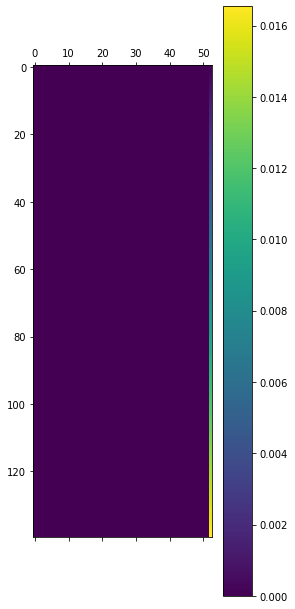

In [57]:
cax = plt.matshow(diff[0])
plt.gcf().colorbar(cax)